# Import

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

PROJECT_DIR = os.path.join(os.path.dirname('lstm_model.ipynb'), os.pardir) + '/..'

In [3]:
# Reading the up-sampled dataset
up_train = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_train.csv', usecols=['Description', 'Accident Level'])
test = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_test.csv', usecols=['Description', 'Accident Level'])
up_train.head()

,Description,Accident Level
0,By manually moving a steel cabinet for disposa...,3
1,Once the mooring of the faneles in the detonat...,1
2,When performing cleaning activity of the area ...,3
3,The technician was doing the magnetometric sur...,1
4,The operator cleaned with spatula spear throug...,1


# Word Cloud

In [4]:
# to generate a wordcloud
from wordcloud import WordCloud

def display_wordcloud(series):
    # Generating wordcloud
    word_cloud = WordCloud(width = 1000, height = 600, background_color ='white', min_font_size = 10)
    word_cloud.generate(' '.join(list(series.apply(lambda x: x.lower()))))

    # plot the WordCloud image                       
    plt.figure(figsize=(6, 6), facecolor = None)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show();

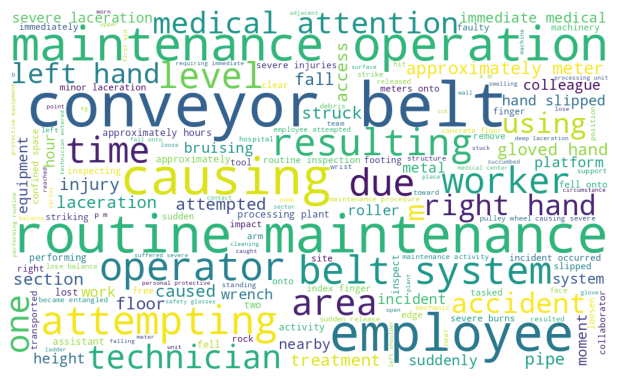

In [5]:
display_wordcloud(up_train['Description'])

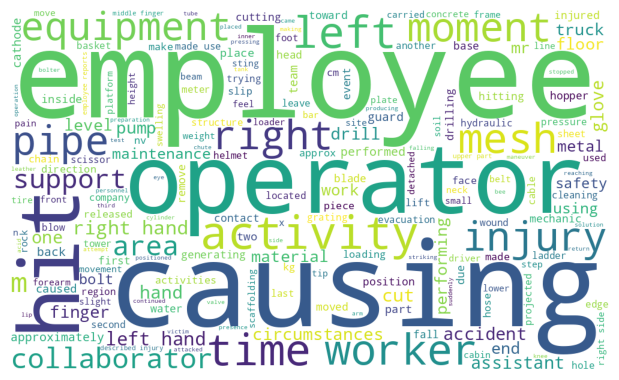

In [6]:
display_wordcloud(test['Description'])

# Tokenization

In [7]:
# Splitting features and targets
x_train = up_train['Description'].str.strip()
y_train = up_train['Accident Level']

x_test = test['Description'].str.strip()
y_test = test['Accident Level']

In [8]:
from tensorflow.keras.layers import TextVectorization

tokenizer = TextVectorization(
    max_tokens=5000,
    output_mode='int',
    standardize='lower_and_strip_punctuation',
)
tokenizer.adapt(x_train)
print('Vocabulary size:', tokenizer.vocabulary_size())
tokenizer.get_vocabulary()

Vocabulary size: 4839


['',
 '[UNK]',
 'the',
 'a',
 'of',
 'to',
 'and',
 'on',
 'in',
 'at',
 'was',
 'his',
 'an',
 'during',
 'maintenance',
 'he',
 'with',
 'causing',
 'from',
 'belt',
 'when',
 'conveyor',
 'as',
 'approximately',
 'routine',
 'hand',
 'while',
 'left',
 'by',
 'for',
 'that',
 'employee',
 'right',
 'area',
 'system',
 'it',
 'severe',
 'operator',
 'medical',
 'onto',
 'operation',
 'level',
 'due',
 'lacerations',
 'caused',
 'him',
 'metal',
 'meters',
 'attempting',
 'resulting',
 'between',
 'technician',
 'worker',
 'equipment',
 'slipped',
 'floor',
 'injuries',
 'bruising',
 'attempted',
 'using',
 'hours',
 'occurred',
 'suddenly',
 'one',
 'their',
 'were',
 'moving',
 'time',
 'sudden',
 'fell',
 'nearby',
 'performing',
 'attention',
 'minor',
 'am',
 'two',
 'accident',
 'injury',
 'safety',
 'activity',
 'into',
 'her',
 '3',
 'fall',
 'which',
 'incident',
 'processing',
 'is',
 'immediate',
 'but',
 'access',
 'pipe',
 'force',
 'finger',
 'section',
 'height',
 'arm'

# Label, One-hot Encoding

In [9]:
# Label encoding to ensure the labels start from 0
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [10]:
# One-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

y_train_ohe

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

# Model LSTM

In [11]:
from tensorflow import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPool1D, Dropout

In [12]:
# Loading pre-trained GloVe word embeddings
EMBEDDING_SIZE = 200
embeddings_dictionary = dict()

glove_file = open(f'{PROJECT_DIR}/models/glove.6B.200d/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [13]:
# Embedding matrix for Descriptions
embedding_matrix = np.zeros((tokenizer.vocabulary_size(), EMBEDDING_SIZE))

for i, word in enumerate(tokenizer.get_vocabulary()):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
def build_lstm():
    model = Sequential()
    model.add(Input(shape=(1,), dtype=string))
    
    model.add(tokenizer)
    model.add(Embedding(
        input_dim=tokenizer.vocabulary_size(),
        output_dim=EMBEDDING_SIZE,
        weights=[embedding_matrix],
        trainable=False
    ))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5, input_shape=(256,)))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5, input_shape=(128,)))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5, input_shape=(64,)))

    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5, input_shape=(32,)))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5, input_shape=(16,)))

    model.add(Dense(5, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(learning_rate=0.001), 
        metrics=['accuracy', Recall(), Precision()]
    )

    return model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    EarlyStopping(monitor='loss', patience=10, min_delta=1e-2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6, verbose=1),
    ModelCheckpoint(PROJECT_DIR + '/models/lstm2', monitor='val_loss', save_best_only=True, initial_value_threshold=1, verbose=1),
    TensorBoard(log_dir=f'{PROJECT_DIR}/reports/tensorboard/')
]

In [16]:
lstm = build_lstm()
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 200)         967800    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        336896    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [17]:
history = lstm.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), batch_size=8, epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
145/145 [==============================] - ETA: 0s - loss: 1.6744 - accuracy: 0.2017 - recall: 0.0017 - precision: 0.1053  
Epoch 1: val_loss did not improve from 1.00000
145/145 [==============================] - 14s 34ms/step - loss: 1.6744 - accuracy: 0.2017 - recall: 0.0017 - precision: 0.1053 - val_loss: 1.6083 - val_accuracy: 0.0762 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 1.6156 - accuracy: 0.2113 - recall: 8.6580e-04 - precision: 0.2500
Epoch 2: val_loss did not improve from 1.00000
145/145 [==============================] - 3s 22ms/step - loss: 1.6156 - accuracy: 0.2113 - recall: 8.6580e-04 - precision: 0.2500 - val_loss: 1.5893 - val_accuracy: 0.7333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 3/100
144/145 [============================>.] - ETA: 0s - loss: 1.6074 - accuracy: 0.2196 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 3: val_lo

INFO:tensorflow:Assets written to: ../../models\lstm2\assets


INFO:tensorflow:Assets written to: ../../models\lstm2\assets


145/145 [==============================] - 14s 98ms/step - loss: 1.0155 - accuracy: 0.5758 - recall: 0.3437 - precision: 0.7393 - val_loss: 0.9575 - val_accuracy: 0.7429 - val_recall: 0.6190 - val_precision: 0.7558 - lr: 0.0010
Epoch 12/100
144/145 [============================>.] - ETA: 0s - loss: 1.0163 - accuracy: 0.5582 - recall: 0.3576 - precision: 0.7423
Epoch 12: val_loss did not improve from 0.95754
145/145 [==============================] - 3s 23ms/step - loss: 1.0195 - accuracy: 0.5584 - recall: 0.3576 - precision: 0.7415 - val_loss: 0.9636 - val_accuracy: 0.7238 - val_recall: 0.6286 - val_precision: 0.7765 - lr: 0.0010
Epoch 13/100
145/145 [==============================] - ETA: 0s - loss: 0.9376 - accuracy: 0.6165 - recall: 0.3983 - precision: 0.7890
Epoch 13: val_loss improved from 0.95754 to 0.91563, saving model to ../../models\lstm2


INFO:tensorflow:Assets written to: ../../models\lstm2\assets


INFO:tensorflow:Assets written to: ../../models\lstm2\assets


145/145 [==============================] - 14s 98ms/step - loss: 0.9376 - accuracy: 0.6165 - recall: 0.3983 - precision: 0.7890 - val_loss: 0.9156 - val_accuracy: 0.7429 - val_recall: 0.7238 - val_precision: 0.7451 - lr: 0.0010
Epoch 14/100
144/145 [============================>.] - ETA: 0s - loss: 0.8927 - accuracy: 0.6241 - recall: 0.4349 - precision: 0.7684
Epoch 14: val_loss did not improve from 0.91563
145/145 [==============================] - 3s 23ms/step - loss: 0.8921 - accuracy: 0.6251 - recall: 0.4346 - precision: 0.7688 - val_loss: 0.9603 - val_accuracy: 0.7143 - val_recall: 0.5810 - val_precision: 0.7439 - lr: 0.0010
Epoch 15/100
143/145 [============================>.] - ETA: 0s - loss: 0.8334 - accuracy: 0.6582 - recall: 0.4677 - precision: 0.8094
Epoch 15: val_loss did not improve from 0.91563
145/145 [==============================] - 3s 22ms/step - loss: 0.8309 - accuracy: 0.6606 - recall: 0.4693 - precision: 0.8114 - val_loss: 0.9808 - val_accuracy: 0.6952 - val_reca

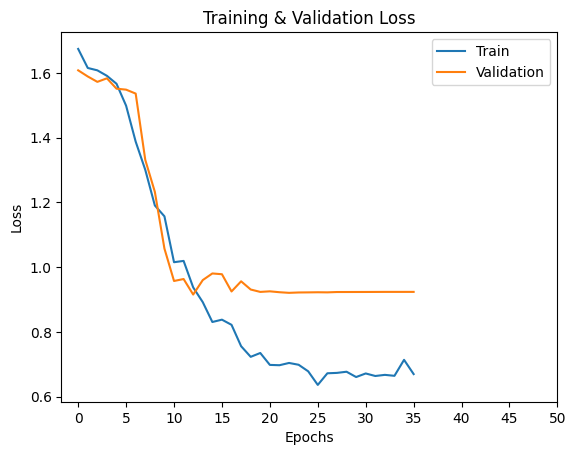

In [18]:
# Loss plot
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0, 55, 5))
plt.legend()
plt.show();

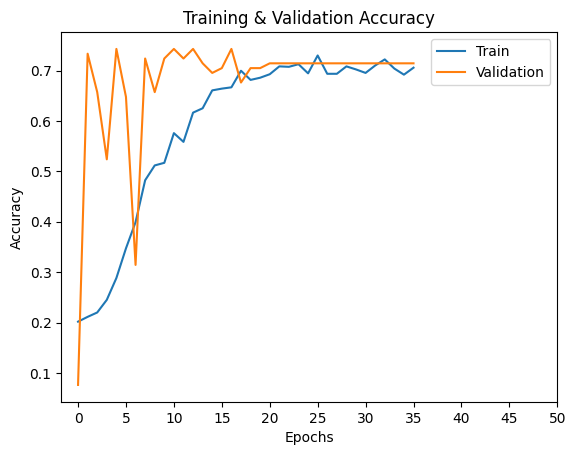

In [19]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 55, 5))
plt.legend()
plt.show();